# Description

The notebook stitches together portfolios for multiple daily prod system runs and plots the resulting PnL curves.

# Imports

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import logging
from typing import Any, Dict, Tuple

import pandas as pd

import core.config as cconfig
import core.plotting as coplotti
import dataflow.model as dtfmod
import helpers.hdbg as hdbg
import helpers.henv as henv
import helpers.hpandas as hpandas
import helpers.hprint as hprint
import oms.reconciliation as omreconc

/app/amp/core/explore.py:39: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  import tqdm.autonotebook as tauton


In [3]:
hdbg.init_logger(verbosity=logging.INFO)

_LOG = logging.getLogger(__name__)

_LOG.info("%s", henv.get_system_signature()[0])

hprint.config_notebook()

INFO: > cmd='/venv/lib/python3.8/site-packages/ipykernel_launcher.py -f /home/.local/share/jupyter/runtime/kernel-6a425e2f-a3bc-48ae-a788-a49a2076a48d.json'
-----------------------------------------------------------------------------
This code is not in sync with the container:
code_version='1.4.2' != container_version='1.5.0'
-----------------------------------------------------------------------------
You need to:
- merge origin/master into your branch with `invoke git_merge_master`
- pull the latest container with `invoke docker_pull`
INFO  # Git
  branch_name='CmTask4872_Run_multiday_system_reconciliation_via_AirFlow'
  hash='140ef4448'
  # Last commits:
    *   140ef4448 Nina Lee Merge branch 'master' into CmTask4872_Run_multiday_system_reconciliation_via_AirFlow (33 minutes ago) Thu Aug 10 01:21:44 2023  (HEAD -> CmTask4872_Run_multiday_system_reconciliation_via_AirFlow, origin/CmTask4872_Run_multiday_system_reconciliation_via_AirFlow)
    |\  
    | * c1542afef DanilYachmenev S

# Build config

In [4]:
# Get config from env when running the notebook via the `run_notebook.py`
# script, e.g., in the system reconciliation flow.
config = cconfig.get_config_from_env()
if config:
    _LOG.info("Using config from env vars")
else:
    _LOG.info("Using hardwired config")
    # Specify the config directly when running the notebook manually.
    # Below is just an example.
    dst_root_dir = "/shared_data/ecs/preprod/prod_reconciliation"
    dag_builder_name = "C3a"
    run_mode = "paper_trading"
    start_timestamp_as_str = "20230716_000000"
    end_timestamp_as_str = "20230723_000000"
    config = omreconc.build_multiday_system_reconciliation_config(
        dst_root_dir,
        dag_builder_name,
        run_mode,
        start_timestamp_as_str,
        end_timestamp_as_str,
    )
    config = config[0]
print(config)

INFO  Using hardwired config
dst_root_dir: /shared_data/ecs/preprod/prod_reconciliation
dag_builder_name: C3a
run_mode: paper_trading
start_timestamp: 2023-07-15 20:00:00-04:00
end_timestamp: 2023-07-22 20:00:00-04:00
pnl_resampling_frequency: 5T


# Functions

In [5]:
# TODO(Grisha): move all functions under `oms/reconciliation.py`.

In [6]:
# TODO(Grisha): can we use this idiom in the other system reconciliation
# notebooks?
def get_prod_dag_output_for_last_node(
    system_log_path_dict: Dict[str, str],
) -> pd.DataFrame:
    """
    Load DAG data for a specified node for all bar timestamps.

    :param system_log_path_dict: system log dirs paths for different experiments
    """
    data_type = "dag_data"
    dag_path_dict = omreconc.get_system_log_paths(system_log_path_dict, data_type)
    hdbg.dassert_in("prod", dag_path_dict.keys())
    hdbg.dassert_path_exists(dag_path_dict["prod"])
    # Get DAG node names.
    dag_node_names = omreconc.get_dag_node_names(dag_path_dict["prod"])
    # Get DAG output for the last node and the last timestamp.
    dag_df_prod = omreconc.load_dag_outputs(
        dag_path_dict["prod"], dag_node_names[-1]
    )
    return dag_df_prod


def compute_research_portfolio(
    dag_df_prod: pd.DataFrame,
    forecast_evaluator_from_prices_dict: Dict[str, Dict[str, Any]],
    start_timestamp: pd.Timestamp,
    end_timestamp: pd.Timestamp,
) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Compute research portfolio and align the indices with the system run start
    and end timestamps.

    :param system_log_path_dict: system log dirs paths for different experiments, e.g.,
        ```
        {
            "prod": "/shared_data/system_log_dir",
            "sim": ...
        }
        ```
    :param forecast_evaluator_from_prices_dict: params to initialize
        `ForecastEvaluatorFromPrices`
    """
    fep = dtfmod.ForecastEvaluatorFromPrices(
        **forecast_evaluator_from_prices_dict["init"]
    )
    annotate_forecasts_kwargs = forecast_evaluator_from_prices_dict[
        "annotate_forecasts_kwargs"
    ].to_dict()
    research_portfolio_df, research_portfolio_stats_df = fep.annotate_forecasts(
        dag_df_prod,
        **annotate_forecasts_kwargs,
    )
    # TODO(Grisha): remove columns sorting if it is not needed.
    research_portfolio_df = research_portfolio_df.sort_index(axis=1)
    research_portfolio_stats_df = research_portfolio_stats_df.sort_index(axis=1)
    # Align index with prod and sim portfolios.
    # TODO(Grisha): remove timestamps filtering if it is not needed.
    research_portfolio_df = research_portfolio_df.loc[
        start_timestamp:end_timestamp
    ]
    research_portfolio_stats_df = research_portfolio_stats_df.loc[
        start_timestamp:end_timestamp
    ]
    return research_portfolio_df, research_portfolio_stats_df

# Load portfolio stats

In [7]:
system_run_params = omreconc.get_system_run_parameters(
    config["dst_root_dir"],
    config["dag_builder_name"],
    config["run_mode"],
    config["start_timestamp"],
    config["end_timestamp"],
)
system_run_params

WARNING Filtered by `start_timestamp`.
WARNING Filtered by `end_timestamp`.
INFO  dst_root_dir='/shared_data/ecs/preprod/prod_reconciliation', dag_builder_name='C3a', run_mode='paper_trading', start_timestamp_as_str='20230716_131000', end_timestamp_as_str='20230717_130500'
INFO  target_dir='/shared_data/ecs/preprod/prod_reconciliation/C3a/paper_trading/20230716_131000.20230717_130500'
INFO  dst_root_dir='/shared_data/ecs/preprod/prod_reconciliation', dag_builder_name='C3a', run_mode='paper_trading', start_timestamp_as_str='20230717_131000', end_timestamp_as_str='20230718_130500'
INFO  target_dir='/shared_data/ecs/preprod/prod_reconciliation/C3a/paper_trading/20230717_131000.20230718_130500'
INFO  dst_root_dir='/shared_data/ecs/preprod/prod_reconciliation', dag_builder_name='C3a', run_mode='paper_trading', start_timestamp_as_str='20230718_131000', end_timestamp_as_str='20230719_130500'
INFO  target_dir='/shared_data/ecs/preprod/prod_reconciliation/C3a/paper_trading/20230718_131000.20230

[('20230716_131000', '20230717_130500', 'scheduled'),
 ('20230717_131000', '20230718_130500', 'scheduled'),
 ('20230718_131000', '20230719_130500', 'scheduled'),
 ('20230719_131000', '20230720_130500', 'scheduled'),
 ('20230720_131000', '20230721_130500', 'scheduled'),
 ('20230721_131000', '20230722_130500', 'scheduled')]

In [8]:
portfolio_stats = []
bar_duration = None
for start_timestamp_as_str, end_timestamp_as_str, mode in system_run_params:
    # Build system reconciliation config.
    config_list = omreconc.build_reconciliation_configs(
        config["dst_root_dir"],
        config["dag_builder_name"],
        start_timestamp_as_str,
        end_timestamp_as_str,
        config["run_mode"],
        mode,
    )
    reconciliation_config = config_list[0]
    system_log_path_dict = reconciliation_config["system_log_path"].to_dict()
    bar_duration = reconciliation_config["meta"]["bar_duration"]
    # Load prod and sim portfolios.
    data_type = "portfolio"
    portfolio_path_dict = omreconc.get_system_log_paths(
        system_log_path_dict, data_type
    )
    portfolio_dfs, portfolio_stats_dfs = omreconc.load_portfolio_dfs(
        portfolio_path_dict,
        bar_duration,
    )
    # Compute research portfolio.
    dag_df_prod = get_prod_dag_output_for_last_node(system_log_path_dict)
    start_timestamp = omreconc.timestamp_as_str_to_timestamp(
        start_timestamp_as_str
    )
    end_timestamp = omreconc.timestamp_as_str_to_timestamp(end_timestamp_as_str)
    forecast_evaluator_from_prices_dict = reconciliation_config[
        "research_forecast_evaluator_from_prices"
    ]
    (
        research_portfolio_df,
        research_portfolio_stats_df,
    ) = compute_research_portfolio(
        dag_df_prod,
        forecast_evaluator_from_prices_dict,
        start_timestamp,
        end_timestamp,
    )
    # Concatenate prod, sim and research portfolios.
    portfolio_stats_dfs["research"] = research_portfolio_stats_df
    portfolio_stats_df = pd.concat(portfolio_stats_dfs, axis=1)
    portfolio_stats.append(portfolio_stats_df)
# Concatenate multiple daily portfolios.
portfolio_stats_df = pd.concat(portfolio_stats, axis=0)
hpandas.df_to_str(portfolio_stats_df, num_rows=5, log_level=logging.INFO)

INFO  run_date='20230716'
INFO  Using run_date=20230716
INFO  dst_root_dir='/shared_data/ecs/preprod/prod_reconciliation', dag_builder_name='C3a', run_mode='paper_trading', start_timestamp_as_str='20230716_131000', end_timestamp_as_str='20230717_130500'
INFO  target_dir='/shared_data/ecs/preprod/prod_reconciliation/C3a/paper_trading/20230716_131000.20230717_130500'
INFO  system_log_dir='system_log_dir.scheduled'
INFO  Processing portfolio=prod path=/shared_data/ecs/preprod/prod_reconciliation/C3a/paper_trading/20230716_131000.20230717_130500/prod/system_log_dir.scheduled/process_forecasts/portfolio


Loading `holdings_shares` files...:   0%|          | 0/288 [00:00<?, ?it/s]

Loading `holdings_notional` files...:   0%|          | 0/288 [00:00<?, ?it/s]

Loading `executed_trades_shares` files...:   0%|          | 0/288 [00:00<?, ?it/s]

Loading `executed_trades_notional` files...:   0%|          | 0/288 [00:00<?, ?it/s]

Loading `statistics` files...:   0%|          | 0/288 [00:00<?, ?it/s]

INFO  Processing portfolio=sim path=/shared_data/ecs/preprod/prod_reconciliation/C3a/paper_trading/20230716_131000.20230717_130500/simulation/system_log_dir/process_forecasts/portfolio


Loading `holdings_shares` files...:   0%|          | 0/288 [00:00<?, ?it/s]

Loading `holdings_notional` files...:   0%|          | 0/288 [00:00<?, ?it/s]

Loading `executed_trades_shares` files...:   0%|          | 0/288 [00:00<?, ?it/s]

Loading `executed_trades_notional` files...:   0%|          | 0/288 [00:00<?, ?it/s]

Loading `statistics` files...:   0%|          | 0/288 [00:00<?, ?it/s]

/venv/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2583: UserWarning: n_quantiles (1001) is greater than the total number of samples (25). n_quantiles is set to n_samples.
  warnings.warn(


INFO  run_date='20230717'
INFO  Using run_date=20230717
INFO  dst_root_dir='/shared_data/ecs/preprod/prod_reconciliation', dag_builder_name='C3a', run_mode='paper_trading', start_timestamp_as_str='20230717_131000', end_timestamp_as_str='20230718_130500'
INFO  target_dir='/shared_data/ecs/preprod/prod_reconciliation/C3a/paper_trading/20230717_131000.20230718_130500'
INFO  system_log_dir='system_log_dir.scheduled'
INFO  Processing portfolio=prod path=/shared_data/ecs/preprod/prod_reconciliation/C3a/paper_trading/20230717_131000.20230718_130500/prod/system_log_dir.scheduled/process_forecasts/portfolio


Loading `holdings_shares` files...:   0%|          | 0/288 [00:00<?, ?it/s]

Loading `holdings_notional` files...:   0%|          | 0/288 [00:00<?, ?it/s]

Loading `executed_trades_shares` files...:   0%|          | 0/288 [00:00<?, ?it/s]

Loading `executed_trades_notional` files...:   0%|          | 0/288 [00:00<?, ?it/s]

Loading `statistics` files...:   0%|          | 0/288 [00:00<?, ?it/s]

INFO  Processing portfolio=sim path=/shared_data/ecs/preprod/prod_reconciliation/C3a/paper_trading/20230717_131000.20230718_130500/simulation/system_log_dir/process_forecasts/portfolio


Loading `holdings_shares` files...:   0%|          | 0/288 [00:00<?, ?it/s]

Loading `holdings_notional` files...:   0%|          | 0/288 [00:00<?, ?it/s]

Loading `executed_trades_shares` files...:   0%|          | 0/288 [00:00<?, ?it/s]

Loading `executed_trades_notional` files...:   0%|          | 0/288 [00:00<?, ?it/s]

Loading `statistics` files...:   0%|          | 0/288 [00:00<?, ?it/s]

/venv/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2583: UserWarning: n_quantiles (1001) is greater than the total number of samples (25). n_quantiles is set to n_samples.
  warnings.warn(


INFO  run_date='20230718'
INFO  Using run_date=20230718
INFO  dst_root_dir='/shared_data/ecs/preprod/prod_reconciliation', dag_builder_name='C3a', run_mode='paper_trading', start_timestamp_as_str='20230718_131000', end_timestamp_as_str='20230719_130500'
INFO  target_dir='/shared_data/ecs/preprod/prod_reconciliation/C3a/paper_trading/20230718_131000.20230719_130500'
INFO  system_log_dir='system_log_dir.scheduled'
INFO  Processing portfolio=prod path=/shared_data/ecs/preprod/prod_reconciliation/C3a/paper_trading/20230718_131000.20230719_130500/prod/system_log_dir.scheduled/process_forecasts/portfolio


Loading `holdings_shares` files...:   0%|          | 0/288 [00:00<?, ?it/s]

Loading `holdings_notional` files...:   0%|          | 0/288 [00:00<?, ?it/s]

Loading `executed_trades_shares` files...:   0%|          | 0/288 [00:00<?, ?it/s]

Loading `executed_trades_notional` files...:   0%|          | 0/288 [00:00<?, ?it/s]

Loading `statistics` files...:   0%|          | 0/288 [00:00<?, ?it/s]

INFO  Processing portfolio=sim path=/shared_data/ecs/preprod/prod_reconciliation/C3a/paper_trading/20230718_131000.20230719_130500/simulation/system_log_dir/process_forecasts/portfolio


Loading `holdings_shares` files...:   0%|          | 0/288 [00:00<?, ?it/s]

Loading `holdings_notional` files...:   0%|          | 0/288 [00:00<?, ?it/s]

Loading `executed_trades_shares` files...:   0%|          | 0/288 [00:00<?, ?it/s]

Loading `executed_trades_notional` files...:   0%|          | 0/288 [00:00<?, ?it/s]

Loading `statistics` files...:   0%|          | 0/288 [00:00<?, ?it/s]

/venv/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2583: UserWarning: n_quantiles (1001) is greater than the total number of samples (25). n_quantiles is set to n_samples.
  warnings.warn(


INFO  run_date='20230719'
INFO  Using run_date=20230719
INFO  dst_root_dir='/shared_data/ecs/preprod/prod_reconciliation', dag_builder_name='C3a', run_mode='paper_trading', start_timestamp_as_str='20230719_131000', end_timestamp_as_str='20230720_130500'
INFO  target_dir='/shared_data/ecs/preprod/prod_reconciliation/C3a/paper_trading/20230719_131000.20230720_130500'
INFO  system_log_dir='system_log_dir.scheduled'
INFO  Processing portfolio=prod path=/shared_data/ecs/preprod/prod_reconciliation/C3a/paper_trading/20230719_131000.20230720_130500/prod/system_log_dir.scheduled/process_forecasts/portfolio


Loading `holdings_shares` files...:   0%|          | 0/288 [00:00<?, ?it/s]

Loading `holdings_notional` files...:   0%|          | 0/288 [00:00<?, ?it/s]

Loading `executed_trades_shares` files...:   0%|          | 0/288 [00:00<?, ?it/s]

Loading `executed_trades_notional` files...:   0%|          | 0/288 [00:00<?, ?it/s]

Loading `statistics` files...:   0%|          | 0/288 [00:00<?, ?it/s]

INFO  Processing portfolio=sim path=/shared_data/ecs/preprod/prod_reconciliation/C3a/paper_trading/20230719_131000.20230720_130500/simulation/system_log_dir/process_forecasts/portfolio


Loading `holdings_shares` files...:   0%|          | 0/288 [00:00<?, ?it/s]

Loading `holdings_notional` files...:   0%|          | 0/288 [00:00<?, ?it/s]

Loading `executed_trades_shares` files...:   0%|          | 0/288 [00:00<?, ?it/s]

Loading `executed_trades_notional` files...:   0%|          | 0/288 [00:00<?, ?it/s]

Loading `statistics` files...:   0%|          | 0/288 [00:00<?, ?it/s]

/venv/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2583: UserWarning: n_quantiles (1001) is greater than the total number of samples (25). n_quantiles is set to n_samples.
  warnings.warn(


INFO  run_date='20230720'
INFO  Using run_date=20230720
INFO  dst_root_dir='/shared_data/ecs/preprod/prod_reconciliation', dag_builder_name='C3a', run_mode='paper_trading', start_timestamp_as_str='20230720_131000', end_timestamp_as_str='20230721_130500'
INFO  target_dir='/shared_data/ecs/preprod/prod_reconciliation/C3a/paper_trading/20230720_131000.20230721_130500'
INFO  system_log_dir='system_log_dir.scheduled'
INFO  Processing portfolio=prod path=/shared_data/ecs/preprod/prod_reconciliation/C3a/paper_trading/20230720_131000.20230721_130500/prod/system_log_dir.scheduled/process_forecasts/portfolio


Loading `holdings_shares` files...:   0%|          | 0/288 [00:00<?, ?it/s]

Loading `holdings_notional` files...:   0%|          | 0/288 [00:00<?, ?it/s]

Loading `executed_trades_shares` files...:   0%|          | 0/288 [00:00<?, ?it/s]

Loading `executed_trades_notional` files...:   0%|          | 0/288 [00:00<?, ?it/s]

Loading `statistics` files...:   0%|          | 0/288 [00:00<?, ?it/s]

INFO  Processing portfolio=sim path=/shared_data/ecs/preprod/prod_reconciliation/C3a/paper_trading/20230720_131000.20230721_130500/simulation/system_log_dir/process_forecasts/portfolio


Loading `holdings_shares` files...:   0%|          | 0/288 [00:00<?, ?it/s]

Loading `holdings_notional` files...:   0%|          | 0/288 [00:00<?, ?it/s]

Loading `executed_trades_shares` files...:   0%|          | 0/288 [00:00<?, ?it/s]

Loading `executed_trades_notional` files...:   0%|          | 0/288 [00:00<?, ?it/s]

Loading `statistics` files...:   0%|          | 0/288 [00:00<?, ?it/s]

/venv/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2583: UserWarning: n_quantiles (1001) is greater than the total number of samples (25). n_quantiles is set to n_samples.
  warnings.warn(


INFO  run_date='20230721'
INFO  Using run_date=20230721
INFO  dst_root_dir='/shared_data/ecs/preprod/prod_reconciliation', dag_builder_name='C3a', run_mode='paper_trading', start_timestamp_as_str='20230721_131000', end_timestamp_as_str='20230722_130500'
INFO  target_dir='/shared_data/ecs/preprod/prod_reconciliation/C3a/paper_trading/20230721_131000.20230722_130500'
INFO  system_log_dir='system_log_dir.scheduled'
INFO  Processing portfolio=prod path=/shared_data/ecs/preprod/prod_reconciliation/C3a/paper_trading/20230721_131000.20230722_130500/prod/system_log_dir.scheduled/process_forecasts/portfolio


Loading `holdings_shares` files...:   0%|          | 0/288 [00:00<?, ?it/s]

Loading `holdings_notional` files...:   0%|          | 0/288 [00:00<?, ?it/s]

Loading `executed_trades_shares` files...:   0%|          | 0/288 [00:00<?, ?it/s]

Loading `executed_trades_notional` files...:   0%|          | 0/288 [00:00<?, ?it/s]

Loading `statistics` files...:   0%|          | 0/288 [00:00<?, ?it/s]

INFO  Processing portfolio=sim path=/shared_data/ecs/preprod/prod_reconciliation/C3a/paper_trading/20230721_131000.20230722_130500/simulation/system_log_dir/process_forecasts/portfolio


Loading `holdings_shares` files...:   0%|          | 0/288 [00:00<?, ?it/s]

Loading `holdings_notional` files...:   0%|          | 0/288 [00:00<?, ?it/s]

Loading `executed_trades_shares` files...:   0%|          | 0/288 [00:00<?, ?it/s]

Loading `executed_trades_notional` files...:   0%|          | 0/288 [00:00<?, ?it/s]

Loading `statistics` files...:   0%|          | 0/288 [00:00<?, ?it/s]

/venv/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2583: UserWarning: n_quantiles (1001) is greater than the total number of samples (25). n_quantiles is set to n_samples.
  warnings.warn(


prod                                                                                             sim                                                                                           research                                                
                                pnl gross_volume  net_volume          gmv          nmv         cash  net_wealth  leverage       pnl gross_volume  net_volume          gmv          nmv         cash  net_wealth  leverage          gmv gross_volume   net_volume         nmv       pnl
2023-07-16 09:10:00-04:00       NaN          0.0         0.0          0.0          0.0        700.0       700.0       0.0       NaN          0.0         0.0          0.0          0.0        700.0       700.0       0.0          NaN          NaN          NaN         NaN       NaN
2023-07-16 09:15:00-04:00       0.0  2977.291636   2234.4357  2977.291636    2234.4357   -1534.4357       700.0  4.253274       0.0  2977.291636   2234.4357  2977.291636    2234.4357   -1534.4357       700.0  4.253274          NaN          NaN          NaN         NaN       NaN
                                ...          ...         ...          ...          ...          ...         ...       ...       ...          ...         ...          ...          ...          ...         ...       ...          ...          ...          ...         ...       ...
2023-07-22 09:00:00-04:00 -0.274366  3493.289522  125.311718  2985.696454   115.465306   582.710124   698.17543  4.276427 -0.274366  3493.289522  125.311718  2985.696454   115.465306   582.710124   698.17543  4.276427  2989.601192  3480.651326   127.406493  111.402047 -0.509687
2023-07-22 09:05:00-04:00  0.917418  4147.627268 -1252.58642  3001.602432 -1136.206696  1835.296544  699.089848  4.293586  0.917418  4147.627268 -1252.58642  3001.602432 -1136.206696  1835.296544  699.089848  4.293586  2991.990851  4161.215098 -1247.478221 -1135.01384  1.062334

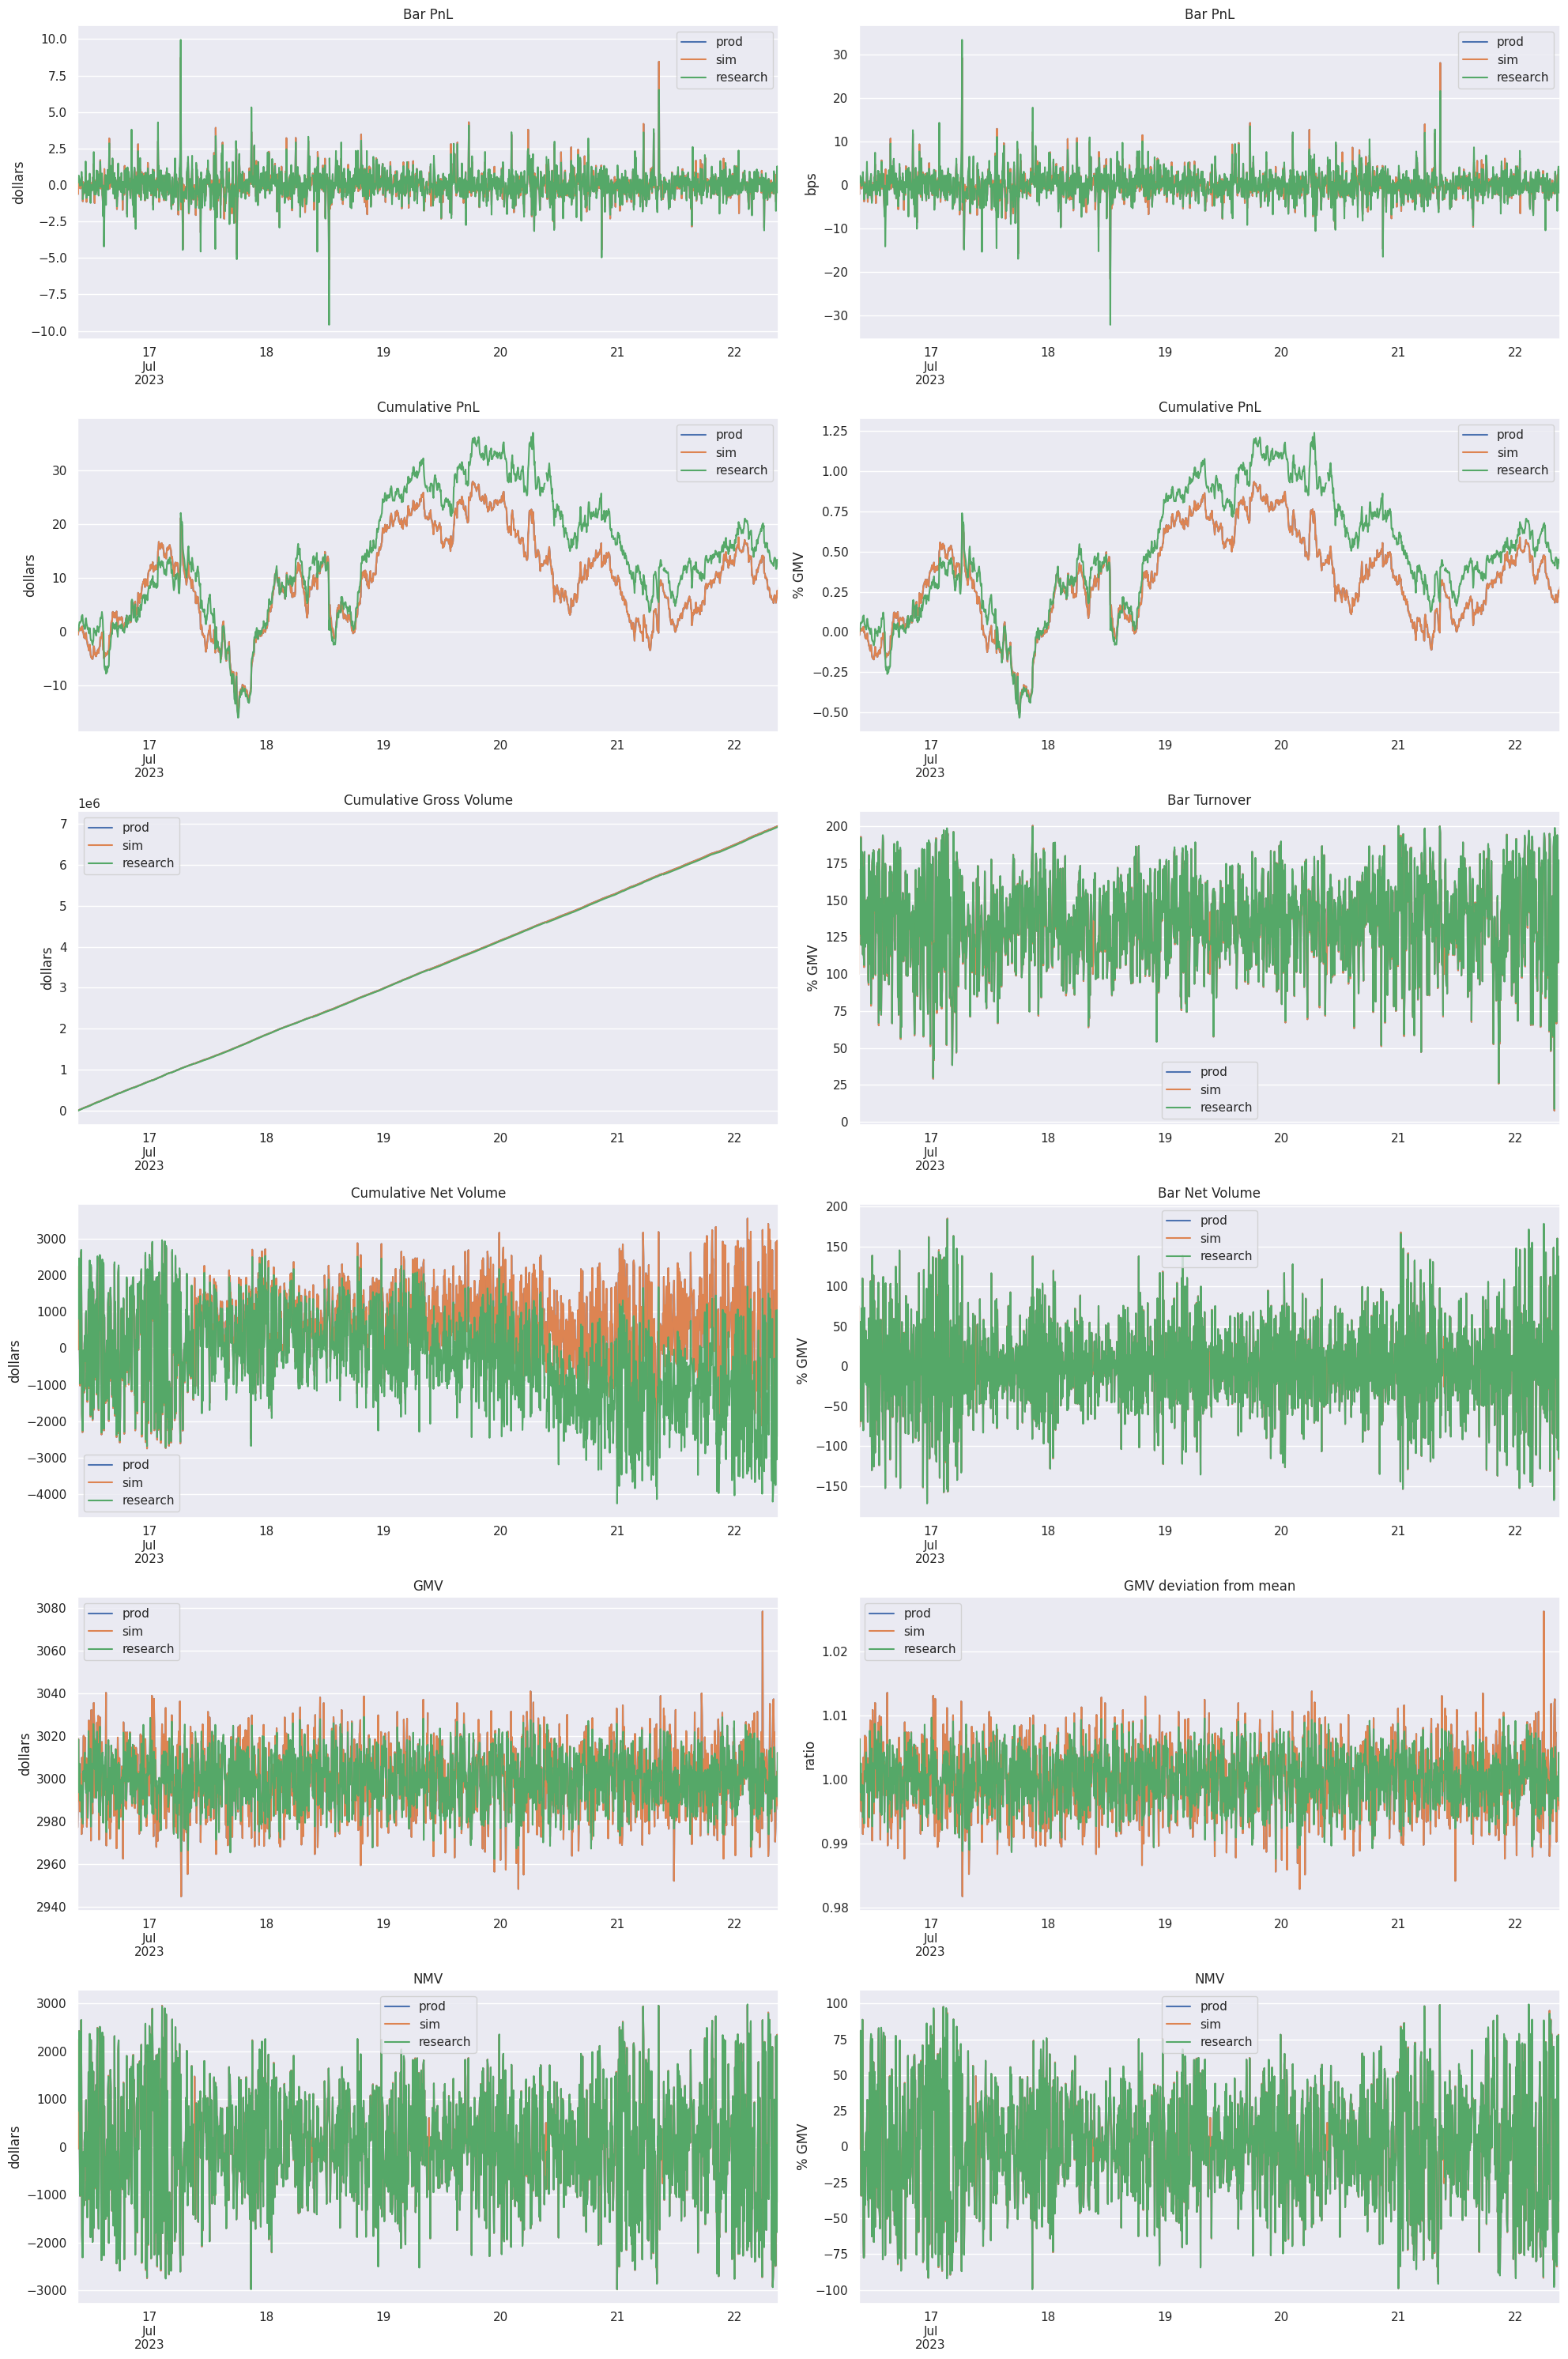

In [9]:
bars_to_burn = 1
coplotti.plot_portfolio_stats(
    portfolio_stats_df.iloc[bars_to_burn:],
    freq=config["pnl_resampling_frequency"],
)

In [10]:
stats_computer = dtfmod.StatsComputer()
stats_sxs, _ = stats_computer.compute_portfolio_stats(
    portfolio_stats_df.iloc[bars_to_burn:], bar_duration
)
display(stats_sxs)

prod      sim  research
ratios     sharpe_ratio                    1.69     1.69      2.57
           sharpe_ratio_standard_error     7.81     7.81      7.81
           sr.tval                         0.22     0.22      0.33
           sr.pval                         0.83     0.83      0.74
           kratio                          2.32     2.32      4.22
dollar     gmv_mean                     2991.04  2991.04   2999.62
           gmv_stdev                     161.94   161.94     12.20
           annualized_mean_return        502.49   503.68    840.95
           annualized_volatility         297.87   297.88    326.96
           max_drawdown                   36.49    36.49     38.13
           pnl_mean                        0.00     0.00      0.01
           pnl_std                         0.92     0.92      1.01
           turnover_mean                4027.76  4027.77   4054.90
           turnover_stdev                941.34   941.36    916.92
           market_bias_mean               10.40    10.40      8.18
           market_bias_stdev            1171.18  1171.19   1174.82
percentage annualized_mean_return         16.80    16.84     28.04
           annualized_volatility           9.96     9.96     10.90
           max_drawdown                    1.22     1.22      1.27
           pnl_mean                        0.00     0.00      0.00
           pnl_std                         0.03     0.03      0.03
           turnover_mean                 134.66   134.66    135.18
           turnover_stdev                 31.47    31.47     30.57
           market_bias_mean                0.35     0.35      0.27
           market_bias_stdev              39.16    39.16     39.17

In [11]:
# Correlate PnLs.
portfolio_stats_df[[("prod", "pnl"), ("sim", "pnl"), ("research", "pnl")]].corr()

,,prod,sim,research
,,pnl,pnl,pnl
prod,pnl,1.000000,1.00000,0.932484
sim,pnl,1.000000,1.00000,0.932480
research,pnl,0.932484,0.93248,1.000000
